# US Churn &mdash; Feature Engineering


## Setup

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display, Markdown
sns.set_style("darkgrid")
pd.set_option("display.max_columns", None)  

import sys, os, yaml

DATASET = "US_Churn"

ROOT = "./"
COLAB = "google.colab" in sys.modules
if COLAB:
    ROOT = f"/content/gdrive/MyDrive/datasets/{DATASET.replace(' ','_')}/"    

DEBUG = False
SEED = 1612

In [42]:
if COLAB:
    from google.colab import drive
    if not os.path.isdir("/content/gdrive"):
        drive.mount("/content/gdrive")

## Imports

In [43]:
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report

## Datasets

In [44]:
df = pd.read_pickle(f"{ROOT}/data/churn.pkl")
print(df.shape)
df.head()

(3333, 20)


,State,Account_Length,Area_Code,Intl_Plan,VMail_Plan,VMail_Message,Day_Mins,Day_Calls,Day_Charge,Eve_Mins,Eve_Calls,Eve_Charge,Night_Mins,Night_Calls,Night_Charge,Intl_Mins,Intl_Calls,Intl_Charge,CustServ_Calls,Churn
0,KS,128,0,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,OH,107,0,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
2,NJ,137,0,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
3,OH,84,2,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
4,OK,75,0,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0


In [45]:
# drop feature that I have not yet considered properly in EDA
for c in ["State"]:
    if c in df.columns: df.drop(c, axis="columns", inplace=True)

## Pre-process Data

In [46]:
df_train, df_test = train_test_split(df, stratify=df.Churn, train_size=0.60, random_state=SEED)
df_train.shape, df_test.shape

((1999, 19), (1334, 19))

In [47]:
target = "Churn"
cat_features = [c for c in df.select_dtypes("category").columns if c not in target]
num_features = [c for c in df.select_dtypes(["int","float"]).columns if c not in target]
features = cat_features + num_features

print(f"Target: {target}")

print(f"Categorical Features: {cat_features}")
print(f"Numerical Features: {num_features}")
print(f"Number of Features: {len(features)}")

Target: Churn
Categorical Features: ['Area_Code', 'Intl_Plan', 'VMail_Plan']
Numerical Features: ['Account_Length', 'VMail_Message', 'Day_Mins', 'Day_Calls', 'Day_Charge', 'Eve_Mins', 'Eve_Calls', 'Eve_Charge', 'Night_Mins', 'Night_Calls', 'Night_Charge', 'Intl_Mins', 'Intl_Calls', 'Intl_Charge', 'CustServ_Calls']
Number of Features: 18


## Feature_Engineering 

Features engineering and selection decisions are carried out on `df_train` ONLY, but resulting operations should be applied to both `df_train` and `df_test`. The simplest way to do this (without repeating code) is to 

 * Perform querys on `df_train` to select new possible features.
 * Apply operations to `df` and repeat the train/test split USING THE SAME SEED.
 * You can use the target values in `df_train` but cannot use the target values in `df_test`.

### New Feature - Cranky Triskaidekaphobias

Would a feature indicating customers who complain and avoid the number 13 be useful in predicting Churn?

This is a silly feature, but illustrates the general procedure

In [48]:
my_query = df_train.query("CustServ_Calls>0 & Day_Calls!=13 & Eve_Calls!=13 & Night_Calls!=13 & Intl_Calls!=13")
my_query.head()

,Account_Length,Area_Code,Intl_Plan,VMail_Plan,VMail_Message,Day_Mins,Day_Calls,Day_Charge,Eve_Mins,Eve_Calls,Eve_Charge,Night_Mins,Night_Calls,Night_Charge,Intl_Mins,Intl_Calls,Intl_Charge,CustServ_Calls,Churn
519,41,2,0,0,0,202.9,97,34.49,153.8,104,13.07,113.5,92,5.11,9.0,3,2.43,3,0
2012,134,2,0,0,0,183.8,111,31.25,123.5,92,10.50,160.7,105,7.23,6.1,2,1.65,1,0
3120,96,0,0,1,21,247.6,95,42.09,256.3,150,21.79,158.6,72,7.14,10.8,6,2.92,2,0
2450,137,1,0,0,0,109.8,120,18.67,230.5,86,19.59,255.8,103,11.51,11.9,6,3.21,1,0
859,93,2,0,0,0,267.9,114,45.54,223.0,74,18.96,262.7,90,11.82,11.3,3,3.05,3,1


In [49]:
df["Cranky_Triskaidekaphobias"] = df.apply (lambda row: (row.CustServ_Calls>0 
            and row.Day_Calls!=13 and row.Eve_Calls!=13 
            and row.Night_Calls!=13 and row.Intl_Calls!=13), axis=1)

### New Features - Total Mins, Calls, Charges

In [50]:
df["Total_Calls"] = df["Day_Calls"] + df["Eve_Calls"] + df["Night_Calls"] + df["Intl_Calls"]
df["Total_Charge"] = df["Day_Charge"] + df["Eve_Charge"] + df["Night_Charge"] + df["Intl_Charge"]
df["Total_Minutes"] = df["Day_Mins"] + df["Eve_Mins"] + df["Night_Mins"] + df["Intl_Mins"]

### New Feature - Average Calls, Charge, Per Minute

In [51]:
df["Avg_Day_Calls_Per_Minute"] = df.apply (lambda row: row.Day_Calls / row.Day_Mins if row.Day_Mins>0 else 0, axis=1)
df["Avg_Eve_Calls_Per_Minute"] = df.apply (lambda row: row.Eve_Calls / row.Eve_Mins if row.Eve_Mins>0 else 0, axis=1)
df["Avg_Night_Calls_Per_Minute"] = df.apply (lambda row: row.Night_Calls / row.Night_Mins if row.Night_Mins>0 else 0, axis=1)
df["Avg_Intl_Calls_Per_Minute"] = df.apply (lambda row: row.Intl_Calls / row.Intl_Mins if row.Intl_Mins>0 else 0, axis=1)
df["Avg_Total_Calls_Per_Minute"] = df.apply (lambda row: row.Total_Calls / row.Total_Minutes if row.Total_Minutes>0 else 0, axis=1)

df["Avg_Day_Charge_Per_Minute"] = df.apply (lambda row: row.Day_Charge / row.Day_Mins if row.Day_Mins>0 else 0, axis=1)
df["Avg_Eve_Charge_Per_Minute"] = df.apply (lambda row: row.Eve_Charge / row.Eve_Mins if row.Eve_Mins>0 else 0, axis=1)
df["Avg_Night_Charge_Per_Minute"] = df.apply (lambda row: row.Night_Charge / row.Night_Mins if row.Night_Mins>0 else 0, axis=1)
df["Avg_Intl_Charge_Per_Minute"] = df.apply (lambda row: row.Intl_Charge / row.Intl_Mins if row.Intl_Mins>0 else 0, axis=1)
df["Avg_Total_Charge_Per_Minute"] = df.apply (lambda row: row.Total_Charge / row.Total_Minutes if row.Total_Minutes>0 else 0, axis=1)

### New Feature - Average Minutes Per Call

In [52]:
df["Avg_Day_Minutes_Per_Call"] = df.apply (lambda row: row.Day_Mins / row.Day_Calls if row.Day_Calls>0 else 0, axis=1)
df["Avg_Eve_Minutes_Per_Call"] = df.apply (lambda row: row.Eve_Mins / row.Eve_Calls if row.Eve_Calls>0 else 0, axis=1)
df["Avg_Night_Minutes_Per_Call"] = df.apply (lambda row: row.Night_Mins / row.Night_Calls if row.Night_Calls>0 else 0, axis=1)
df["Avg_Intl_Minutes_Per_Call"] = df.apply (lambda row: row.Intl_Mins / row.Intl_Calls if row.Intl_Calls>0 else 0, axis=1)
df["Avg_Total_Minutes_Per_Call"] = df.apply (lambda row: row.Total_Minutes / row.Total_Calls if row.Total_Calls>0 else 0, axis=1)

### Pre-Processing Data (2)

In [53]:
df_train, df_test = train_test_split(df, stratify=df[target], test_size=.40, random_state=SEED)
features = df.columns.tolist()
if target in features: features.remove(target)
print(f"Number of features {len(features)}\n{features}")

Number of features 37
['Account_Length', 'Area_Code', 'Intl_Plan', 'VMail_Plan', 'VMail_Message', 'Day_Mins', 'Day_Calls', 'Day_Charge', 'Eve_Mins', 'Eve_Calls', 'Eve_Charge', 'Night_Mins', 'Night_Calls', 'Night_Charge', 'Intl_Mins', 'Intl_Calls', 'Intl_Charge', 'CustServ_Calls', 'Cranky_Triskaidekaphobias', 'Total_Calls', 'Total_Charge', 'Total_Minutes', 'Avg_Day_Calls_Per_Minute', 'Avg_Eve_Calls_Per_Minute', 'Avg_Night_Calls_Per_Minute', 'Avg_Intl_Calls_Per_Minute', 'Avg_Total_Calls_Per_Minute', 'Avg_Day_Charge_Per_Minute', 'Avg_Eve_Charge_Per_Minute', 'Avg_Night_Charge_Per_Minute', 'Avg_Intl_Charge_Per_Minute', 'Avg_Total_Charge_Per_Minute', 'Avg_Day_Minutes_Per_Call', 'Avg_Eve_Minutes_Per_Call', 'Avg_Night_Minutes_Per_Call', 'Avg_Intl_Minutes_Per_Call', 'Avg_Total_Minutes_Per_Call']


In [54]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = scaler.fit_transform(df_train.loc[:,features].values)
y_train = df_train.Churn.values

X_test = scaler.transform(df_test.loc[:,features].values)
y_test = df_test.Churn.values

## Model Selection

In [55]:
models = {
    "LR": LogisticRegression(),
    "DT": DecisionTreeClassifier(),
    "DT(max_depth=3)": DecisionTreeClassifier(max_depth=3),
    "KNN": KNeighborsClassifier(),
    "SVC": SVC(),
}

def train_models():
    best = {"name":None, "mean":0}
    
    for name,model in models.items():
    
        scores = cross_val_score(model, X_train, y_train, scoring="accuracy", cv=10)
        mean = scores.mean()
        std = scores.std()
        
        print ("\nModel %s" % name)
        print ("\tCV scores: " +  ", ".join([f"{s:.2f}" for s in scores]))
        print (f"\tmean={mean:.2%} std={std:.4f}")
    
        if mean>best['mean']:
            best = {'name':name, 'mean':mean}

    print (f"\nBest Performing Model {best['name']} with (mean CV of) accuracy = {best['mean']:.2%}" )
    

In [56]:
train_models()


Model LR
	CV scores: 0.90, 0.88, 0.86, 0.87, 0.85, 0.88, 0.90, 0.86, 0.87, 0.88
	mean=87.54% std=0.0138

Model DT
	CV scores: 0.93, 0.94, 0.95, 0.96, 0.94, 0.94, 0.95, 0.95, 0.95, 0.93
	mean=94.50% std=0.0090

Model DT(max_depth=3)
	CV scores: 0.96, 0.96, 0.94, 0.93, 0.96, 0.95, 0.93, 0.96, 0.94, 0.93
	mean=94.75% std=0.0123

Model KNN
	CV scores: 0.91, 0.90, 0.89, 0.92, 0.89, 0.90, 0.86, 0.89, 0.89, 0.89
	mean=89.19% std=0.0136

Model SVC
	CV scores: 0.94, 0.93, 0.91, 0.93, 0.93, 0.91, 0.91, 0.90, 0.91, 0.92
	mean=91.70% std=0.0107

Best Performing Model DT(max_depth=3) with (mean CV of) accuracy = 94.75%


## Feature Selection

Next we are going to try to reduce the number of features using [RFECV](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html) a recursive feature elimination with cross-validation function.

RFECV needs a classifier that returns information about feature importance either through a `coef_` attribute or through a `feature_importances_` attribute. 
Of our models given above will work, only `LogisticRegression` and `DT` provide this information


In [57]:
print("Number of features starting:", len(features))

Number of features starting: 37


Optimal number of features : 21


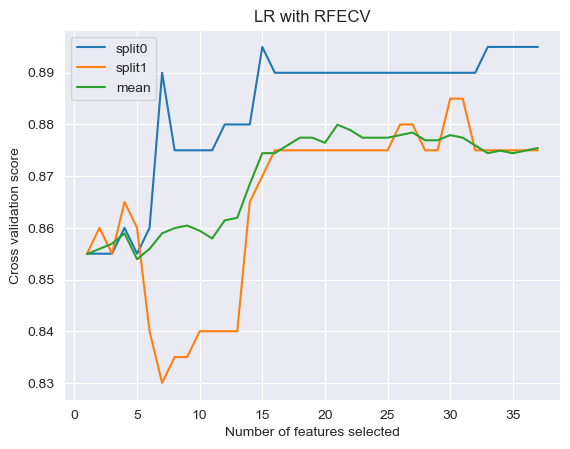

In [58]:
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

name = "LR"  # use LR, DT
model = models[name]

rfecv = RFECV(estimator=model, step=1, cv=StratifiedKFold(10), scoring="accuracy")
rfecv.fit(X_train, y_train)
print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.title(f"{name} with RFECV")
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score")
results = rfecv.cv_results_
plt.plot(range(1, len(results["mean_test_score"]) + 1), results["split0_test_score"], label="split0")
plt.plot(range(1, len(results["mean_test_score"]) + 1), results["split1_test_score"], label="split1")
plt.plot(range(1, len(results["mean_test_score"]) + 1), results["mean_test_score"], label="mean")
plt.legend()
plt.show()

In [59]:
len(rfecv.support_), len(features)

(37, 37)

In [60]:
# list of features selected
if len(rfecv.support_)<len(features):
    print("It looks like you have run cells out of order. Runn cells from Pre-Processing Data (2)")

features_selected = np.array(features)[rfecv.support_].tolist()
features_selected

['Intl_Plan',
 'VMail_Plan',
 'VMail_Message',
 'Day_Mins',
 'Day_Charge',
 'Eve_Calls',
 'Night_Mins',
 'Night_Charge',
 'Intl_Mins',
 'Intl_Calls',
 'CustServ_Calls',
 'Cranky_Triskaidekaphobias',
 'Total_Calls',
 'Total_Charge',
 'Total_Minutes',
 'Avg_Day_Calls_Per_Minute',
 'Avg_Total_Calls_Per_Minute',
 'Avg_Intl_Charge_Per_Minute',
 'Avg_Total_Charge_Per_Minute',
 'Avg_Eve_Minutes_Per_Call',
 'Avg_Total_Minutes_Per_Call']

### Training - After Feature Selection

In [61]:
display(df.loc[:, features_selected + [target]].head(1))

# normalise 
X_train = scaler.fit_transform(df_train.loc[:,features_selected].values)
y_train = df_train.Churn.values
X_test = scaler.transform(df_test.loc[:,features_selected].values)
y_test = df_test.Churn.values

train_models()

,Intl_Plan,VMail_Plan,VMail_Message,Day_Mins,Day_Charge,Eve_Calls,Night_Mins,Night_Charge,Intl_Mins,Intl_Calls,CustServ_Calls,Cranky_Triskaidekaphobias,Total_Calls,Total_Charge,Total_Minutes,Avg_Day_Calls_Per_Minute,Avg_Total_Calls_Per_Minute,Avg_Intl_Charge_Per_Minute,Avg_Total_Charge_Per_Minute,Avg_Eve_Minutes_Per_Call,Avg_Total_Minutes_Per_Call,Churn
0,0,1,25,265.1,45.07,99,244.7,11.01,10.0,3,1,True,303,75.56,717.2,0.414938,0.422476,0.27,0.105354,1.993939,2.366997,0



Model LR
	CV scores: 0.89, 0.88, 0.87, 0.86, 0.88, 0.89, 0.90, 0.87, 0.86, 0.89
	mean=87.84% std=0.0124

Model DT
	CV scores: 0.94, 0.96, 0.95, 0.94, 0.95, 0.95, 0.94, 0.94, 0.93, 0.93
	mean=94.55% std=0.0104

Model DT(max_depth=3)
	CV scores: 0.96, 0.96, 0.94, 0.93, 0.96, 0.95, 0.93, 0.96, 0.94, 0.93
	mean=94.75% std=0.0123

Model KNN
	CV scores: 0.92, 0.92, 0.91, 0.91, 0.92, 0.92, 0.89, 0.89, 0.91, 0.87
	mean=90.44% std=0.0150

Model SVC
	CV scores: 0.94, 0.93, 0.93, 0.94, 0.94, 0.92, 0.93, 0.93, 0.93, 0.92
	mean=93.05% std=0.0086

Best Performing Model DT(max_depth=3) with (mean CV of) accuracy = 94.75%


## Submit

 * Creates zip file to upload of notebooks in project

In [62]:
import glob
from zipfile import ZipFile

archive = f"{ROOT}/US_Churn_-_Feature_Engineering.zip"

if COLAB:
    files_to_upload = list(glob.glob("/content/gdrive/MyDrive/Colab Notebooks/US_Churn*.ipynb"))
else: 
    files_to_upload = list(glob.glob("US_Churn*.ipynb"))
print(f"Creating zip archive with notebooks {files_to_upload} ...")

with ZipFile(archive,"w") as zip:
    for file in files_to_upload:
        basename = file.split("/Colab Notebooks/")[-1]
        zip.write(file, basename) 

Creating zip archive with notebooks ['US_Churn-01-Import.ipynb', 'US_Churn-02-EDA.ipynb', 'US_Churn-03-Baseline_Model.ipynb', 'US_Churn-04-Feature_Engineering.ipynb'] ...
